#### <span style="color:#grey"> __Formation South Green 2022 - Structural Variants Detection by using short and long reads__ </span>

# <span style="color:#006E7F">  <center> __DAY 2 : How to analyze mapping results ?__ </center> </span>

Created by C. Tranchant (DIADE-IRD), J. Orjuela (DIADE-IRD), F. Sabot (DIADE-IRD) and A. Dereeper (PHIM-IRD)

***

# <span style="color: #006E7F">Table of contents</span>
<a class="anchor" id="home"></a>

[I - Get some basic mapping stats with samtools flagstat](#mappingstats)

* [Run samtools flagstat](#flagstat)
* [Samtools flagstat output](#flagstatoutput)
* [Merge individual flagstat files into an unique file with python code](#multiflagstat) 
* [Plot mapping ratio per sample](#ratioplot)
* [EXERCICE : DO THE SAME MANIP WITH MINIMAP2 RESULTS](#minimap)

[II - Get some basic stats from vcf files](#statvcf) 
* [Count the number of variants with `bcftools stat`](#bcftools)
* [Generating statistics from a VCF to determining how to set filters on it](#vcffilters)
* [Generating density plot QUAL & DEPTH](#vcfplot) 

[III - FILTERING VCF](#vcffiltering)

</span>

***



## <span style="color:#006E7F">__I - Get some basic mapping stats with samtools flagstat__ <a class="anchor" id="mappingstats"></span>  

### <span style="color: #4CACBC;"> First go into the directory that contains all the bam files</span>  


In [46]:
%cd /home/jovyan/work/MAPPING-ILL/
%ls

/home/jovyan/work/MAPPING-ILL
dirClone1/   dirClone12/  dirClone15/  dirClone18/  dirClone4/  dirClone7/
dirClone10/  dirClone13/  dirClone16/  dirClone2/   dirClone5/  dirClone8/
dirClone11/  dirClone14/  dirClone17/  dirClone3/   dirClone6/  dirClone9/


### <span style="color: #4CACBC;">Grouping the flagstat files previosly created</span>  

* Create the subdirectory FLAGSTAT into the directory MAPPING_ILL
* copy the flagstat files previously generated into this new directry

In [58]:
%%bash
pwd
mkdir -p FLAGSTAT
cp dir*/*flagstat FLAGSTAT

/home/jovyan/work/MAPPING-ILL


#### <span style="color: #4CACBC;">Check that the flagstat files have been correctly copied</span>

In [62]:
ls FLAGSTAT

all_stat.csv      Clone14.flagstat  Clone2.flagstat  Clone7.flagstat
Clone10.flagstat  Clone15.flagstat  Clone3.flagstat  Clone8.flagstat
Clone11.flagstat  Clone16.flagstat  Clone4.flagstat  Clone9.flagstat
Clone12.flagstat  Clone17.flagstat  Clone5.flagstat
Clone13.flagstat  Clone1.flagstat   Clone6.flagstat


### <span style="color: #4CACBC;">Let's look the content of one flagstat file <a class="anchor" id="flagstatoutput"></span> 

In [63]:
cat FLAGSTAT/Clone10*stat

296107 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 duplicates
221301 + 0 mapped (74.74%:-nan%)
296107 + 0 paired in sequencing
148037 + 0 read1
148070 + 0 read2
218229 + 0 properly paired (73.70%:-nan%)
219681 + 0 with itself and mate mapped
1620 + 0 singletons (0.55%:-nan%)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### <span style="color: #4CACBC;">Merge individual flagstat files into an unique file with python code <a class="anchor" id="multiflagstat"></span> 

In [54]:
# IMPORT PYTHON PACKAGE USED BY THE CODE
import os
import pandas as pd

# VARIABLE INITIALIZATION

## NAME OF THE DIRECTORY THAT CONTAINS FLAGSTAT FILES
flagstat_dir = "/home/jovyan/work/MAPPING-ILL/FLAGSTAT" #PUT THE DIRECTORY NAME THAT CONTAINS FLAGSTAT FILES 

## NAME OF THE FILE THAT WILL CONTAIN ALL THE FLAGSTAT RESULTATS
stat_file = f"{flagstat_dir}/all_stat.csv"

# PRINT THE CONTENT OF 2 PREVIOUS VARIABLES INITIALIZED
print("DIRECTORY : ",flagstat_dir)
print("FINAL STAT FILE : ",stat_file)


DIRECTORY :  /home/jovyan/work/MAPPING-ILL/FLAGSTAT
FINAL STAT FILE :  /home/jovyan/work/MAPPING-ILL/FLAGSTAT/all_stat.csv


In [60]:
%pwd

'/home/jovyan/work/MAPPING-ILL'

In [65]:
# OPEN THE FINAL FILE IN WHICH WE PRINT SOME STATS EXTRACTED FROM EACH INDIVIDUAL FILE GENERATED BY SAMTOOLS FLAGSTAT
with open(stat_file, 'w') as stat: 
    # WRITE A HEADER LINE IN OUR STAT FILE
    header_line = "sample,mapped,paired,unmapped"
    stat.write(header_line)
    
    # READING EACH FILE OF THE FLGSTAT DIRECTORY
    for file in os.listdir(flagstat_dir):
        # If flagstat is in name of file
        filen = flagstat_dir + "/" + file
        if "flagstat" in file:
            # Extract sample name and save into a new variable newLine 
            new_line = f"\n{file.split('.')[0]},"
            # OPEN AND READS FLAGSTAT FILE
            with open(filen, "r") as flagstat:
                # read file line by line
                for line in flagstat:
                    # remove the line skipper at the endo of the line
                    line = line.rstrip()              
                    # Keep only line mapped, paired or singleton word
                    if 'mapped (' in line or 'paired (' in line or 'singleton' in line:
                        # get percentage value and save it into the varaible called perc
                        perc = f"{line.split('(')[1].split('%')[0]}"
                        new_line += f"{perc},"
                # WRITE THE LINE ONCE THE FLAGSTAT FILE COMPLETELY READ
                stat.write(new_line.strip(","))

Clone9.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone9.flagstat
Clone1.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone1.flagstat
Clone6.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone6.flagstat
Clone3.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone3.flagstat
Clone16.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone16.flagstat
Clone7.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone7.flagstat
Clone2.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone2.flagstat
Clone10.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone10.flagstat
Clone15.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone15.flagstat
all_stat.csv
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/all_stat.csv
Clone17.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone17.flagstat
Clone12.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone12.flagstat
Clone5.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone5.flagstat
Clone11.flagstat
/home/jovyan/work/MAPPING-ILL/FLAGSTAT/Clone11.flagstat


### <span style="color: #4CACBC;">Display the content of the final stat file  <a class="anchor" id="statfile"></span> 

In [66]:
%cat $stat_file

sample,mapped,paired,unmapped
Clone9,80.41,79.70,0.49
Clone1,100.00,100.00,0.00
Clone6,85.92,85.49,0.41
Clone3,100.00,100.00,0.00
Clone16,75.52,66.81,0.43
Clone7,65.75,64.94,0.77
Clone2,100.00,100.00,0.00
Clone10,74.74,73.70,0.55
Clone15,73.85,68.41,0.50
Clone17,76.06,72.69,0.52
Clone12,73.02,71.07,0.58
Clone5,89.23,89.00,0.22
Clone11,75.20,73.85,0.53
Clone13,78.18,75.93,0.53
Clone4,99.56,99.53,0.01
Clone14,78.03,74.84,0.55
Clone8,49.62,48.40,1.14

### <span style="color: #4CACBC;">Plot mapping ratio per sample <a class="anchor" id="ratioplot"></a></span> 

#### Load csv file into a panda datafrale


In [67]:
df_bam_stat = pd.read_csv(stat_file, index_col=False, sep=",")
df_bam_stat

,sample,mapped,paired,unmapped
0,Clone9,80.41,79.70,0.49
1,Clone1,100.00,100.00,0.00
2,Clone6,85.92,85.49,0.41
3,Clone3,100.00,100.00,0.00
4,Clone16,75.52,66.81,0.43
5,Clone7,65.75,64.94,0.77
6,Clone2,100.00,100.00,0.00
7,Clone10,74.74,73.70,0.55
8,Clone15,73.85,68.41,0.50
9,Clone17,76.06,72.69,0.52


#### Basic stats

In [68]:
# Je n'affiche que les valeurs de la colonne "mapped"
print(df_bam_stat['mapped'])

0      80.41
1     100.00
2      85.92
3     100.00
4      75.52
5      65.75
6     100.00
7      74.74
8      73.85
9      76.06
10     73.02
11     89.23
12     75.20
13     78.18
14     99.56
15     78.03
16     49.62
Name: mapped, dtype: float64


In [70]:
# J affiche la moyenne, min et max de cette colonne
minimum = df_bam_stat["mapped"].min()
maximun = df_bam_stat["mapped"].max()
mean_flag = df_bam_stat["mapped"].mean()

print("\n######## BASIC STATS\n MAPPED")       
print(f"\t%min : {minimum}\t %max : {maximun}\t %mean : {mean_flag}")



######## BASIC STATS
 MAPPED
	%min : 49.62	 %max : 100.0	 %mean : 80.88764705882352


<AxesSubplot:xlabel='sample', ylabel='paired'>

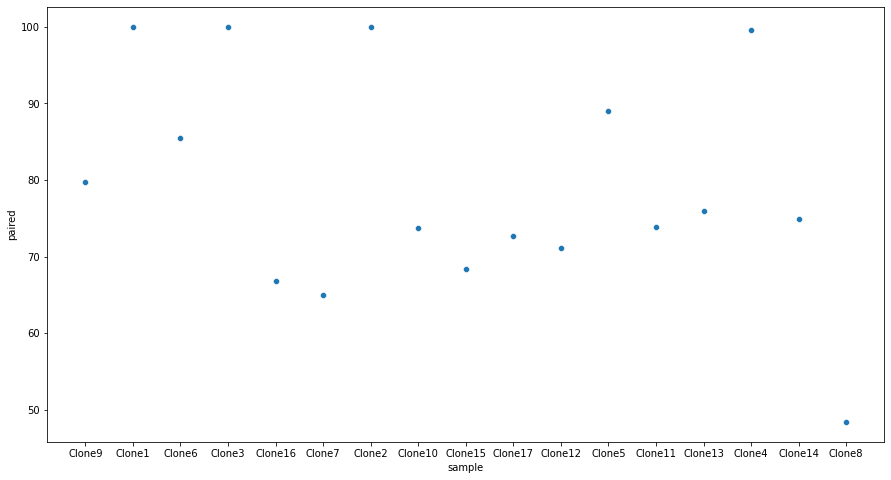

In [72]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15,8))
sns.scatterplot(x="sample",y="paired", data=df_bam_stat)

Text(0, 0.5, 'Mapping percentage')

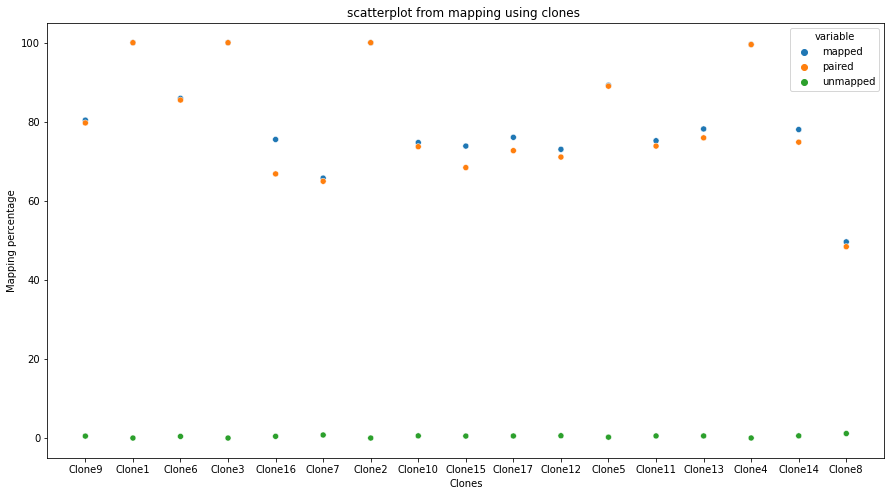

In [73]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15,8))
ax=sns.scatterplot(x="sample",y="value", hue='variable', data=pd.melt(df_bam_stat, 'sample'))
ax.set_title("scatterplot from mapping using clones ")
ax.set_xlabel("Clones")
ax.set_ylabel("Mapping percentage")

### <span style="color: #4CACBC;"> EXERCICE : DO THE SAME THING WITH MINIMAP2 RESULTS <a class="anchor" id="minimap"></span> 

## <span style="color:#006E7F">__II. Get some basic stats from vcf files__ <a class="anchor" id="statvcf"></a></span> 

In this exercise, we are going to work with a REAL vcf from the IRIGIN project in rice.

#### Firstly, download the directory that contains the vcf into the subdirectory `work` and decompress it
link : https://itrop.ird.fr/sv-training/VCF_REAL.tar.gz

In [ ]:
%%bash
cd /home/jovyan/work/
wget https://itrop.ird.fr/sv-training/VCF_REAL.tar.gz
tar zxvf VCF_REAL.tar.gz
rm VCF_REAL.tar.gz

### <span style="color: #4CACBC;">First go into the directory that contains vcf file  </span> 

* List the content of this directory


In [129]:
cd /home/jovyan/work/VCF_REAL/

/home/jovyan/work/VCF_REAL


In [130]:
ls

AF2.frq             genome-Osativa-MSU7.dict*    rice-CHR6.200000.vcf.gz.tbi
AF.frq              genome-Osativa-MSU7.fa*      rice-CHR6.200000.vcf.stat
all-gene.gff3*      genome-Osativa-MSU7.fa.fai*  VCF_REAL.vcf.stat
depthi.idepth       qual.lqual
depths.ldepth.mean  rice-CHR6.200000.vcf.gz


### <span style="color: #4CACBC;">Count the number of variants with `bcftools stat`<a class="anchor" id="bcftools"></a></span> 

* run the bcftools stats on the vcf file and save the result into the file `rice-CHR6.200000.vcf.stat`
* check that the file have been correctly created and display the 35 first lines of this file
* How many samples were used for this SNP analysis ?
* How many SNPs were detected ?

In [81]:
%%bash
bcftools stats rice-CHR6.200000.vcf.gz >  rice-CHR6.200000.vcf.stat

In [84]:
%%bash
head -n 35 rice-CHR6.200000.vcf.stat

# This file was produced by bcftools stats (1.10.2+htslib-1.10.2-3) and can be plotted using plot-vcfstats.
# The command line was:	bcftools stats  rice-CHR6.200000.vcf.gz
#
# Definition of sets:
# ID	[2]id	[3]tab-separated file names
ID	0	rice-CHR6.200000.vcf.gz
# SN, Summary numbers:
#   number of records   .. number of data rows in the VCF
#   number of no-ALTs   .. reference-only sites, ALT is either "." or identical to REF
#   number of SNPs      .. number of rows with a SNP
#   number of MNPs      .. number of rows with a MNP, such as CC>TT
#   number of indels    .. number of rows with an indel
#   number of others    .. number of rows with other type, for example a symbolic allele or
#                          a complex substitution, such as ACT>TCGA
#   number of multiallelic sites     .. number of rows with multiple alternate alleles
#   number of multiallelic SNP sites .. number of rows with multiple alternate alleles, all SNPs
# 
#   Note that rows containing multiple types

### <span style="color: #4CACBC;">Generating statistics from a VCF to determine how to set filters on it<a class="anchor" id="vcffilters"></a></span> `vcftools`

We will generate more statistics from a VCF using vcftools (LINK MANUAL), a very useful and fast program for handling vcf files 
to easily calculate these statistics in order to better define filters we will apply and to get an idea of how to set such filtering thresholds. 

The main information we will consider are:
* Depth: Usually, we filter SNP with a minimum and maximum depth. We use a minimum depth cutoffs to remove false positive calls and to keep higher quality calls too. 
A maximum cut off allow to remove regions with very, very high read depths such as repetitive regions.
* Quality Genotype quality : With this filter, we should not trust any genotype with a Phred score below 20 which suggests a less than 99% accuracy.
* Minor allele frequency MAF can cause big problems with SNP calls - and also inflate statistical estimates downstream. Ideally you want an idea of the distribution of your 
allelic frequencies but 0.05 to 0.10 is a reasonable cut-off. You should keep in mind however that some analyses, particularly demographic inference can be biased by MAF thresholds.
* Missing data How much missing data are you willing to tolerate? It will depend on the study but typically any site with >25% missing data should be dropped.
* biallelic, heterozygosity...

In this training, we will just display quality and depth distribution... but you should do on each value filterd.

#### <span style="color: #4CACBC;">Mean depth per individual and per site<a class="anchor" id="depthvcf"></a></span> `--depth, --site-mean-depth`

* run vcftool with the correct options
* check that the files have been created and display the first lines

In [ ]:
%%bash
vcftools --gzvcf rice-CHR6.200000.vcf.gz --depth --out depthi
vcftools --gzvcf rice-CHR6.200000.vcf.gz --site-mean-depth --out depths

In [86]:
%%bash
ls -lrt
head *depth*

total 252876
-rw-r--r-- 1 jovyan users     24891 Jun 19 16:39 rice-CHR6.200000.vcf.gz.tbi
-rw-r--r-- 1 jovyan users 253125332 Jun 19 16:39 rice-CHR6.200000.vcf.gz
-rw-r--r-- 1 jovyan users         0 Jun 19 20:30 VCF_REAL.vcf.stat
-rw-r--r-- 1 jovyan users     50465 Jun 19 20:31 rice-CHR6.200000.vcf.stat
-rw-r--r-- 1 jovyan users      4498 Jun 19 20:36 depthi.idepth
-rw-r--r-- 1 jovyan users   5720362 Jun 19 20:37 depths.ldepth.mean
==> depthi.idepth <==
INDV	N_SITES	MEAN_DEPTH
AA	162582	25.2283
AB	159135	21.2978
AC	160124	21.902
AD	163847	25.1102
AE	159110	19.0267
AF	165415	33.5353
AG	161801	24.3954
AH	163295	28.4362
AI	163854	28.6535

==> depths.ldepth.mean <==
CHROM	POS	MEAN_DEPTH	VAR_DEPTH
Chr6	1226	1.65455	0.711785
Chr6	1254	2.0625	2.31516
Chr6	1268	2.15217	3.55411
Chr6	1314	2.42857	3.43915
Chr6	1589	1.25	0.25
Chr6	1635	1.42857	0.285714
Chr6	1778	8.25	8.5
Chr6	1929	1	0
Chr6	2102	9.55556	11.9085


#### <span style="color: #4CACBC;">Extracting quality per site<a class="anchor" id="depthvcf"></a></span>  `--site-quality`

* run vcftool with the correct options
* check that the files have been created and display the first lines

In [ ]:
%%bash
vcftools --gzvcf rice-CHR6.200000.vcf.gz  --site-quality --out qual

In [88]:
%%bash
ls -lrt
head *qual

total 256964
-rw-r--r-- 1 jovyan users     24891 Jun 19 16:39 rice-CHR6.200000.vcf.gz.tbi
-rw-r--r-- 1 jovyan users 253125332 Jun 19 16:39 rice-CHR6.200000.vcf.gz
-rw-r--r-- 1 jovyan users         0 Jun 19 20:30 VCF_REAL.vcf.stat
-rw-r--r-- 1 jovyan users     50465 Jun 19 20:31 rice-CHR6.200000.vcf.stat
-rw-r--r-- 1 jovyan users      4498 Jun 19 20:36 depthi.idepth
-rw-r--r-- 1 jovyan users   5720362 Jun 19 20:37 depths.ldepth.mean
-rw-r--r-- 1 jovyan users   4183898 Jun 19 20:41 qual.lqual
CHROM	POS	QUAL
Chr6	1226	1489.9
Chr6	1254	860.98
Chr6	1268	712.14
Chr6	1314	402.88
Chr6	1589	94.92
Chr6	1635	196.87
Chr6	1778	161.71
Chr6	1929	1000.64
Chr6	2102	198.31



__Calculate allele frequency__

* --freq2 : outputs the frequencies without information about the alleles
* --freq would return their identity. 
* --max-alleles 2 to exclude sites that have more than two alleles.

In [118]:
%%bash
vcftools --gzvcf rice-CHR6.200000.vcf.gz --freq --out AF --max-alleles 2
vcftools --gzvcf rice-CHR6.200000.vcf.gz --freq2 --out AF2 --max-alleles 2
ls -lrt
head *.frq


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf rice-CHR6.200000.vcf.gz
	--max-alleles 2
	--freq
	--out AF

Using zlib version: 1.2.11
After filtering, kept 250 out of 250 Individuals
Outputting Frequency Statistics...
After filtering, kept 193027 out of a possible 200000 Sites
Run Time = 14.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf rice-CHR6.200000.vcf.gz
	--max-alleles 2
	--freq2
	--out AF2

Using zlib version: 1.2.11
After filtering, kept 250 out of 250 Individuals
Outputting Frequency Statistics...
After filtering, kept 193027 out of a possible 200000 Sites
Run Time = 15.00 seconds


total 270048
-rw-r--r-- 1 jovyan users     24891 Jun 19 16:39 rice-CHR6.200000.vcf.gz.tbi
-rw-r--r-- 1 jovyan users 253125332 Jun 19 16:39 rice-CHR6.200000.vcf.gz
-rw-r--r-- 1 jovyan users         0 Jun 19 20:30 VCF_REAL.vcf.stat
-rw-r--r-- 1 jovyan users     50465 Jun 19 20:31 rice-CHR6.200000.vcf.stat
-rw-r--r-- 1 jovyan users      4498 Jun 19 20:36 depthi.idepth
-rw-r--r-- 1 jovyan users   5720362 Jun 19 20:37 depths.ldepth.mean
-rw-r--r-- 1 jovyan users   4183898 Jun 19 20:41 qual.lqual
-rw-r--r-- 1 jovyan users   7118360 Jun 20 06:10 AF.frq
-rw-r--r-- 1 jovyan users   6276310 Jun 20 06:11 AF2.frq
==> AF2.frq <==
CHROM	POS	N_ALLELES	N_CHR	{FREQ}
Chr6	1226	2	110	0	1
Chr6	1254	2	96	0.177083	0.822917
Chr6	1268	2	92	0.25	0.75
Chr6	1314	2	56	0.410714	0.589286
Chr6	1589	2	8	0	1
Chr6	1635	2	14	0	1
Chr6	1778	2	16	0.25	0.75
Chr6	1929	2	24	0.25	0.75
Chr6	2102	2	36	0.583333	0.416667

==> AF.frq <==
CHROM	POS	N_ALLELES	N_CHR	{ALLELE:FREQ}
Chr6	1226	2	110	C:0	G:1
Chr6	1254	2	96	C:0.177083	T:0.8

### <span style="color: #4CACBC;">Generating density plot QUAL & DEPTH<a class="anchor" id="vcfplot"></a></span> 

#### <span style="color: #4CACBC;">Plotting quality per site<a class="anchor" id="qualplot"></a></span> 

In [119]:
qual_file="qual.lqual"
df_qual = pd.read_csv(qual_file, index_col=False, sep="\t")
print(df_qual)
df_qual['QUAL'].describe()

       CHROM       POS       QUAL
0       Chr6      1226    1489.90
1       Chr6      1254     860.98
2       Chr6      1268     712.14
3       Chr6      1314     402.88
4       Chr6      1589      94.92
...      ...       ...        ...
199995  Chr6  31247304     642.96
199996  Chr6  31247496     209.98
199997  Chr6  31247528     105.57
199998  Chr6  31247549  131262.00
199999  Chr6  31247577      72.38

[200000 rows x 3 columns]


count    2.000000e+05
mean     5.235163e+04
std      9.891222e+04
min      3.000000e+01
25%      3.927700e+02
50%      2.598330e+03
75%      4.708460e+04
max      1.678550e+06
Name: QUAL, dtype: float64

<AxesSubplot:xlabel='QUAL', ylabel='Density'>

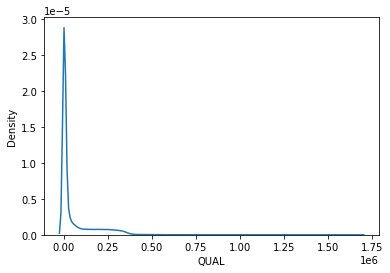

In [115]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x="QUAL", data=df_qual)

Text(0, 0.5, 'PUT A Y-AXIS LABEL')

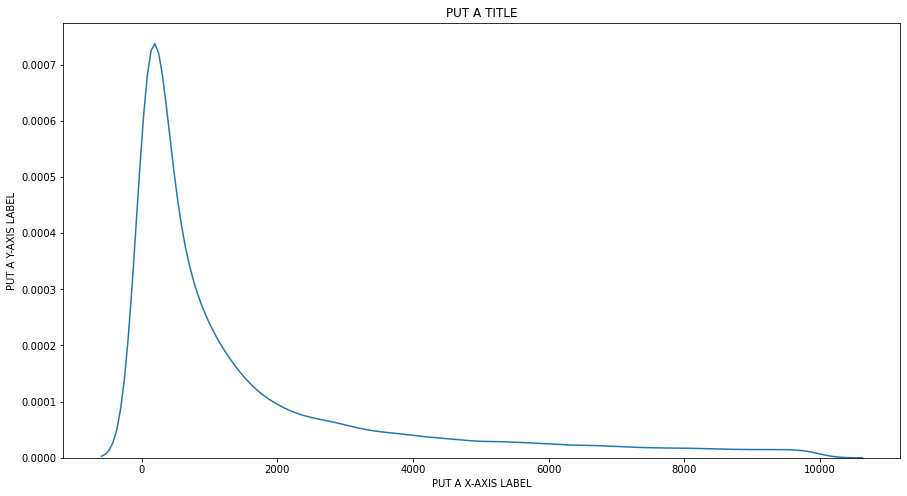

In [122]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize = (15,8))
ax=sns.kdeplot(x="QUAL", data=df_qual[df_qual.QUAL<10000])
ax.set_title("PUT A TITLE")
ax.set_xlabel("PUT A X-AXIS LABEL")
ax.set_ylabel("PUT A Y-AXIS LABEL")

#### <span style="color: #4CACBC;">Plotting Mean depth per site<a class="anchor" id="depthplot"></a></span> 

In [105]:
depth_file="depths.ldepth.mean"
df_depth = pd.read_csv(depth_file, index_col=False, sep="\t")
print(df_depth)
df_depth.describe()

       CHROM       POS  MEAN_DEPTH   VAR_DEPTH
0       Chr6      1226     1.65455    0.711785
1       Chr6      1254     2.06250    2.315160
2       Chr6      1268     2.15217    3.554110
3       Chr6      1314     2.42857    3.439150
4       Chr6      1589     1.25000    0.250000
...      ...       ...         ...         ...
199995  Chr6  31247304    10.80470  115.765000
199996  Chr6  31247496     5.97674   31.632300
199997  Chr6  31247528     7.35714   28.979300
199998  Chr6  31247549    87.56400  946.022000
199999  Chr6  31247577   248.94800    1.093670

[200000 rows x 4 columns]


,POS,MEAN_DEPTH,VAR_DEPTH
count,2.000000e+05,200000.000000,199820.000000
mean,1.564023e+07,22.808144,86.517654
std,8.301304e+06,20.553295,214.784320
min,1.226000e+03,1.000000,0.000000
25%,9.194011e+06,8.254960,18.035850
50%,1.546369e+07,22.060000,55.759600
75%,2.239793e+07,32.196000,83.481925
max,3.124758e+07,250.000000,11162.600000


Text(0, 0.5, 'PUT A Y-AXIS LABEL')

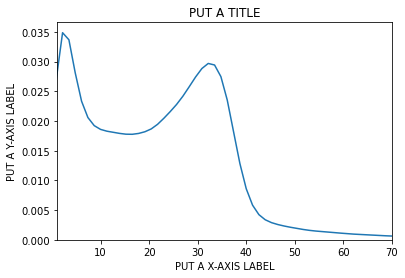

In [125]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

ax=sns.kdeplot(x="MEAN_DEPTH", data=df_depth)
ax.set_xlim(1, 70)
ax.set_title("PUT A TITLE")
ax.set_xlabel("PUT A X-AXIS LABEL")
ax.set_ylabel("PUT A Y-AXIS LABEL")

Text(0, 0.5, 'PUT A Y-AXIS LABEL')

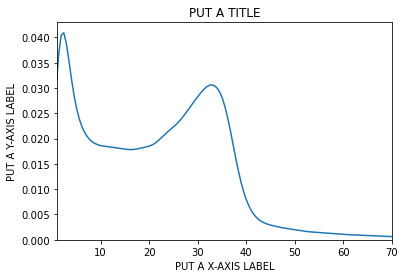

In [126]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

ax=sns.kdeplot(x="MEAN_DEPTH", data=df_depth[df_depth.MEAN_DEPTH<100])
ax.set_xlim(1, 70)
ax.set_title("PUT A TITLE")
ax.set_xlabel("PUT A X-AXIS LABEL")
ax.set_ylabel("PUT A Y-AXIS LABEL")

### <span style="color: #4CACBC;">III - FILTERING VCF <a class="anchor" id="vcffiltering"></a></span> 


#### Which filters ?

Here, we will apply on the vcf the following filters :

* QUAL > 3000
* DP > 10 and DP < 20000
* Less than 3 SNPs into a window of 10pb

The threshodl of each filter depends on the SNP analysis (sample number, sequencing depth).

In a second step, according the following analysys (eg: population genomics), usually, we will apply other filters such as :
* removing missing data
* keeping only biallellic
* heterozygosity
    
#### Select only the SNPs (and remove the INDELs) - `gatk variantFiltration`
* Filter vcf to keep only SNPs
* Check that the new vcf has been created
* Get the number of polymorphisms in the new vcf file 

In [142]:
%%bash
gatk SelectVariants --java-options "-Xmx8G -Xms8G" -R genome-Osativa-MSU7.fa -V rice-CHR6.200000.vcf.gz -select-type SNP -O rice-CHR6.200000.onlySNP.vcf

Using GATK jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx8G -Xms8G -jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar SelectVariants -R genome-Osativa-MSU7.fa -V rice-CHR6.200000.vcf.gz -select-type SNP -O rice-CHR6.200000.onlySNP.vcf
06:45:21.252 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
06:45:21.420 INFO  SelectVariants - ------------------------------------------------------------
06:45:21.420 INFO  SelectVariants - The Genome Analysis Toolkit (GATK) v4.2.6.1
06:45:21.420 INFO  SelectVariants - For support and documentation go to https://software.broadinstitute.org/gatk/
06:45:21.425 INFO  SelectVariants - Initializing engine
06:45:21

In [137]:
%%bash
ls -lrth
bcftools stats rice-CHR6.200000.onlySNP.vcf | head -n35

total 1.6G
-rw-r--r-- 1 jovyan users  25K Jun 19 16:39 rice-CHR6.200000.vcf.gz.tbi
-rw-r--r-- 1 jovyan users 242M Jun 19 16:39 rice-CHR6.200000.vcf.gz
-rw-r--r-- 1 jovyan users    0 Jun 19 20:30 VCF_REAL.vcf.stat
-rw-r--r-- 1 jovyan users  50K Jun 19 20:31 rice-CHR6.200000.vcf.stat
-rw-r--r-- 1 jovyan users 4.4K Jun 19 20:36 depthi.idepth
-rw-r--r-- 1 jovyan users 5.5M Jun 19 20:37 depths.ldepth.mean
-rw-r--r-- 1 jovyan users 4.0M Jun 19 20:41 qual.lqual
-rw-r--r-- 1 jovyan users 6.8M Jun 20 06:10 AF.frq
-rw-r--r-- 1 jovyan users 6.0M Jun 20 06:11 AF2.frq
-rwxr-xr-x 1 jovyan users 5.2M Jun 20 06:19 all-gene.gff3
-rwxr-xr-x 1 jovyan users 1.7K Jun 20 06:19 genome-Osativa-MSU7.dict
-rwxr-xr-x 1 jovyan users  479 Jun 20 06:19 genome-Osativa-MSU7.fa.fai
-rwxr-xr-x 1 jovyan users 365M Jun 20 06:19 genome-Osativa-MSU7.fa
-rw-r--r-- 1 jovyan users 959M Jun 20 06:35 rice-CHR6.200000.onlySNP.vcf
-rw-r--r-- 1 jovyan users 123K Jun 20 06:35 rice-CHR6.200000.onlySNP.vcf.idx
# This file was produce

#### Compress the vcf and generate the index of the compressed vcf - `tabix -p vcf vcf_file`

In [144]:
%%bash
bgzip rice-CHR6.200000.onlySNP.vcf
ls -lrth

AF2.frq
AF.frq
all-gene.gff3
depthi.idepth
depths.ldepth.mean
genome-Osativa-MSU7.dict
genome-Osativa-MSU7.fa
genome-Osativa-MSU7.fa.fai
qual.lqual
rice-CHR6.200000.onlySNP.vcf.gz
rice-CHR6.200000.onlySNP.vcf.idx
rice-CHR6.200000.vcf.gz
rice-CHR6.200000.vcf.gz.tbi
rice-CHR6.200000.vcf.stat
VCF_REAL.vcf.stat


In [150]:
%%bash
tabix -f -p vcf rice-CHR6.200000.onlySNP.vcf.gz
ls -lrth

total 842M
-rw-r--r-- 1 jovyan users  25K Jun 19 16:39 rice-CHR6.200000.vcf.gz.tbi
-rw-r--r-- 1 jovyan users 242M Jun 19 16:39 rice-CHR6.200000.vcf.gz
-rw-r--r-- 1 jovyan users    0 Jun 19 20:30 VCF_REAL.vcf.stat
-rw-r--r-- 1 jovyan users  50K Jun 19 20:31 rice-CHR6.200000.vcf.stat
-rw-r--r-- 1 jovyan users 4.4K Jun 19 20:36 depthi.idepth
-rw-r--r-- 1 jovyan users 5.5M Jun 19 20:37 depths.ldepth.mean
-rw-r--r-- 1 jovyan users 4.0M Jun 19 20:41 qual.lqual
-rw-r--r-- 1 jovyan users 6.8M Jun 20 06:10 AF.frq
-rw-r--r-- 1 jovyan users 6.0M Jun 20 06:11 AF2.frq
-rwxr-xr-x 1 jovyan users 5.2M Jun 20 06:19 all-gene.gff3
-rwxr-xr-x 1 jovyan users 1.7K Jun 20 06:19 genome-Osativa-MSU7.dict
-rwxr-xr-x 1 jovyan users  479 Jun 20 06:19 genome-Osativa-MSU7.fa.fai
-rwxr-xr-x 1 jovyan users 365M Jun 20 06:19 genome-Osativa-MSU7.fa
-rw-r--r-- 1 jovyan users 123K Jun 20 06:45 rice-CHR6.200000.onlySNP.vcf.idx
-rw-r--r-- 1 jovyan users 208M Jun 20 06:47 rice-CHR6.200000.onlySNP.vcf.gz
-rw-r--r-- 1 jovyan 

#### Applying filters on QUAL, DEPTH and CLUSTER SNPsSelect only the SNPs (and remove the INDELs) - `gatk variantFiltration`

In [ ]:
%%bash
gatk VariantFiltration --java-options "-Xmx12G -Xms12G" -R genome-Osativa-MSU7.fa -V rice-CHR6.200000.onlySNP.vcf.gz --filter-expression "QUAL<200" --filter-name "LOW_QUAL" --filter-expression "DP<10" --filter-name "LOW_DP"     --cluster-size 3 --cluster-window-size 10     --filter-expression "DP>20000" --filter-name "HIGH-DP" -O rice-CHR6.200000.filteredSNP.vcf

Using GATK jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx12G -Xms12G -jar /opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar VariantFiltration -R genome-Osativa-MSU7.fa -V rice-CHR6.200000.onlySNP.vcf.gz --filter-expression QUAL<200 --filter-name LOW_QUAL --filter-expression DP<10 --filter-name LOW_DP --cluster-size 3 --cluster-window-size 10 --filter-expression DP>20000 --filter-name HIGH-DP -O rice-CHR6.200000.filteredSNP.vcf
06:58:50.339 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/conda/share/gatk4-4.2.6.1-1/gatk-package-4.2.6.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
06:58:50.905 INFO  VariantFiltration - ------------------------------------------------------------
06:58:50.906 INFO  VariantFiltration - The Genome Analysis Tool

In [ ]:
ls -lrtht

In [ ]:
bgzip rice-CHR6.200000.onlySNP.vcf
tabix -p vcf 
ls -lrtht

#### _Commands to apply other filters_

##### remove missing data if more than 5% of missing data at a site (12 samples over 228 samples) `vcftools`

`vcftools --vcf input.vcf --max-missing-count 12 --remove-filtered-all --recode --recode-INFO-all  --out ouput.onlySNP.12na`

##### keep SNPs with only 90% homzygous (222 samples)

`cat input.vcf | java -jar SnpSift.jar filter " (countHom( )> 222) " > output.onlySNP.12na.recode.222homoz.vcf`

##### keep only biallelic sites
`vcftools --vcf input.vcf --min-alleles 2 --max-alleles 2 --remove-filtered-all --recode --recode-INFO-all --out output.onlySNP.filteredPASS.na.225.Homoz.biallelic`

### <span style="color: #4CACBC;">IV - VCF ANNOTATION <a class="anchor" id="vcffiltering"></a></span> 

java -jar snpEff.jar -v -o statschr6.onlySNP.html rice6.1 input.vcf > output.snpeff.vcf

In [ ]:
df_csv_stat["MAF"]=df_csv_stat[['ALL1', 'ALL2']].min(axis=1)


In [ ]:
print(df_csv_stat[df_csv_stat.ALL1>0.70])

In [ ]:
# Plot with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x="MAF", data=df_csv_stat)

In [ ]:
cd $vcf_dir

In [ ]:
%%bash
wget --no-check-certificat https://itrop.ird.fr/sv-training/out.vcf.gz

In [ ]:
ls

In [ ]:
%%bash
zgrep -vc "^#" out.vcf.gz | head

In [ ]:
%%bash
REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
cd /home/jovyan/work/MAPPING-ILL/VCF/
#tail -n 50 /home/jovyan/work/MAPPING-ILL/VCF/Clone1.g.vcf
gatk CombineGVCFs -R $REF --variant Clone1.g.vcf --variant Clone2.g.vcf  -O final.vcf

In [ ]:
%%bash

REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
cd /home/jovyan/work/MAPPING-ILL/VCF/
ls -lrt
head -n 1000 final.vcf | tail

gatk --java-options "-Xmx4g" GenotypeGVCFs -R $REF -V final.vcf -O final.genotype.vcf

In [ ]:
%%bash

REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
cd /home/jovyan/work/MAPPING-ILL/VCF/
ls -lrt
head -n 1000 final.genotype.vcf | tail


In [ ]:
%%bash

REF="/home/jovyan/work/DATA/Clone10/referenceCorrect.fasta"
VCF=home/jovyan/work/MAPPING-ILL/VCF/final.genotype.vcf
cd /home/jovyan/work/MAPPING-ILL/VCF/f
grep  -vc "^#" /

bcftools stats /home/jovyan/work/MAPPING-ILL/VCF/final.genotype.vcf | head -n 50

In [ ]:
eles, --freq would return their identity. We need to add max-alleles 2 to exclude sites that have more than two alleles.

vcftools --gzvcf $SUBSET_VCF --freq2 --out $OUT --max-alleles 2

In [ ]:
grep -vc "^#" out.vcf.gz